# Map/Reduce Affinity Propagation Clustering Algorithm 

Nous avons choisis de traiter le sujet proposé au titre des années 2016-2017 visant à implémenter l'algorithme dit Affinity Propagation (AP) sur de larges bases de données grâce à la technique Map/Reduce. 

L'étude que nous avons faite se base sur l'article écrit par Wei-Chih Hung, Chun-Yen Chu, and Yi-Leh Wu de la National Taiwan University of Science and Technology et par Cheng-Yuan Tang de la Huafan University à Taiwan. L'article s'intitule "Map/Reduce Affinity Propagation Clustering Algorithm" et porte sur l'implémentation de la méthode AP pour répartir de larges bases de données en groupes dits clusters. 

Cet algorithme présente plusieurs particularités très appréciables pour une démarche de clusterisation: 

- Le nombre de clusters ne doit pas être fixé à l'avance 
- La démarche mathématique est relativement simple et converge assez rapidement
- L'algorithme s'applique à tout types de données du moment qu'elles sont numériques
- Son implémentation est relativement rapide (certaines bibliothèques existent déjà)

Le principal défaut de l'algorithme AP est son coût en mémoire. En effet, pour exécuter l'algorithme AP sur une base de données de X lignes, il faut générer une matrice de taille X² afin de stocker toutes les valeurs à mettre à jour. Cela en fait un algorithme qui atteint vite ses limites sur de larges bases de données car une machine seule n'est pas capable de gérer facilement des tableaux d'une telle taille. 

Le but de ce code est donc: 

- Dans un premier temps de présenter les données à traiter et de les mettre en forme
- Appliquer l'algorithme AP sur une fraction des données sans utiliser Map/Reduce et critiquer le résultat
- Appliquer l'algorithme AP à l'ensemble des données grâce au langage PIG et critiquer les résultats.
- Comparer les résultats à l'algorithme K-means

L'article sur lequel est basé ce code est disponible à l'adresse suivante:

http://www.ijeee.net/uploadfile/2014/0807/20140807114023665.pdf

In [1]:
### Importation de toutes les bibliothèques nécessaires à l'exécution du code

%matplotlib inline

import numpy as np
import sklearn as sk
import pandas as pd
from timeit import default_timer as timer
import datetime as dt

print("Done")

Done


# Importation des données

Les données choisies pour appliquer l'algorithme sont des données tirées de Kaggle. Ces données sont disponibles à l'adresse suivante : https://www.kaggle.com/hugomathien/soccer/kernels

Nous avons le droit de les utiliser car le but de ce code n'est pas commercial mais académique. 

Cette base de données contient de nombreuses données concernant les matchs de football européen durant les dernières années et contient notamment pour un certain nombre de joueurs (11060) leurs statistiques tirées du jeu vidéo FIFA ainsi que d'autres caractéristiques (droitier, gaucher, date de naissance).

La base de données fournie par Kaggle est au format sqlite. Nous avons donc eus recours au logiciel **DB Browser for SQLite** pour exploiter cette base de données et en exporter les tables ***Player*** et ***Player_Attributes*** au format .csv

Ces deux tables sont donc celles que nous importons dans ce notebook et allons tenter de fusionner avant d'appliquer l'algorithme AP sur la base de données obtenue.

In [2]:
### Lors de l'importation, nous remplaçons toutes les valeurs manquantes par 0.0 car il n'y aucune valeur manquante dans les 
### colonnes de variables de type String

t0 = timer()

df_player = pd.read_csv("Player.csv",sep=',')
df_player = df_player.fillna(0.0)

df_player_attributes = pd.read_csv("Player_Attributes.csv", sep=',')
df_player_attributes = df_player_attributes.fillna(0.0)

print("runtime = {} s".format(timer() - t0))

runtime = 4.9468229103780486 s


In [3]:
### Aperçu de la table Player

df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [4]:
### Aperçu de la table Player_Attributes

df_player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [5]:
### Nous cherchons à comprendre laquelle des deux tables à le plus grand index
### au regard de la clef commune choisie : player_api_id

id_attributes = df_player_attributes["player_api_id"].values
id_attributes.sort()
id_player = df_player["player_api_id"].values
id_player.sort()

if(len(id_attributes) < len(id_player)):
    print("Minimum index is in attributes")
else:
    print("Minimum index is in players")

Minimum index is in players


In [6]:
### Nous traitons tout d'abord la dataframe df_player_attributes qui comportent plusieurs occurences sur un certain nombre
### de joueurs. Ces joueurs sont en fait identiques mais leurs statistiques ont été mises à jour au fur et à mesure des 
### des versions du jeu FIFA. Nous convertissons donc les dates des mises à jour en écart à aujourd'hui dans un premier temps

li_temp = [dt.datetime.today() - dt.datetime.strptime(e,"%Y-%m-%d %H:%M:%S") for e in df_player_attributes['date'].values]
li_temp = [e.days for e in li_temp]

df_player_attributes['date'] = li_temp
df_player_attributes.columns = [e for e in df_player_attributes.columns]
df_player_attributes.tail()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
183973,183974,102359,750435,2713,83.0,85.0,right,medium,low,84.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,183975,102359,750435,2902,78.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,183976,102359,750435,3078,77.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,183977,102359,750584,3444,78.0,81.0,right,medium,low,74.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0
183977,183978,102359,750584,3633,80.0,81.0,right,medium,low,74.0,...,88.0,53.0,38.0,32.0,30.0,9.0,9.0,78.0,7.0,15.0


In [7]:
### De la même manière, nous convertissons la colonne des dates de naissance des joueurs dans la table Players en une colonne
### âge afin de transformer une variable de type String en une variable numérique

li_col = [e for e in df_player.columns[:4]] + ['age'] + [e for e in df_player.columns[5:]]

li_age = [dt.datetime.today() - dt.datetime.strptime(e,"%Y-%m-%d %H:%M:%S") for e in df_player['birthday'].values]
li_age = [np.trunc(e.days/365) for e in li_age]

df_player.columns = li_col
df_player['age'] = li_age
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,age,height,weight
0,1,2625,Aaron Appindangoye,218353,24.0,182.88,187
1,2,2752,Aaron Cresswell,189615,27.0,170.18,146
2,3,2768,Aaron Doran,186170,25.0,170.18,163
3,4,2770,Aaron Galindo,140161,34.0,182.88,198
4,5,2790,Aaron Hughes,17725,37.0,182.88,154


In [8]:
### Nous nous sommes rendus compte que les deux tables Player et Players_Attributes comportent le même nombre de valeurs uniques
### de la clef player_api_id. Avant de fusionner ces deux tables nous prenons donc le parti de ne garder que la version la plus
### à jour des statistiques du joueur dans la table Player_Attributes. Cela nous mène à créer une nouvelle dataframe qui 
### contient donc l'index commun, les valeurs uniques de player_api_id, et la version la plus à jour des statistiques des joueurs.
### Cela est possible facilement grâce à l'étape précédente de transformation des dates en écart à aujourd'hui.

t0 = timer()

df_temp = df_player_attributes.set_index('player_api_id')

df_attributes = pd.DataFrame(index = df_player_attributes['player_api_id'].drop_duplicates(), columns = df_player_attributes.columns)
df_attributes = df_attributes.drop(['player_api_id'], axis = 1)

for e in df_attributes.index:
    
    df_attributes.loc[e] = df_temp.loc[e].sort('date').iloc[0]

print("runtime = {} s".format(timer() - t0))

C:\Users\xelle\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


runtime = 37.93614095565659 s


In [9]:
### Aperçu de la table Attributes nouvellement créée

df_attributes.head()

,id,player_fifa_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,6,189615,287,74,76,left,high,medium,80,53,...,66,59,76,75,78,14,7,9,9,12
2752,15,189615,790,71,77,left,medium,medium,78,50,...,64,58,73,72,72,13,6,8,8,11
2768,39,186170,392,65,67,right,medium,medium,64,58,...,68,61,23,22,24,16,11,12,9,13
2770,65,140161,287,69,69,right,medium,medium,57,21,...,54,37,72,71,68,15,12,13,12,11
2790,72,140161,811,67,67,right,medium,medium,56,20,...,53,36,66,68,65,14,11,12,11,10


In [10]:
### Nous fusionnons donc ici les deux tables en supprimant les colonnes inutiles à l'algorithme AP
### Nous commençons par définir les colonnes à conserver dans la table Player et créons les mêmes colonnes dans la table 
### Attributes avant de les remplir des valeurs adéquates

t0 = timer()

li_col_player = [e for e in df_player.columns[2:] if e!= 'player_fifa_api_id']

df_attributes = df_attributes.drop(["id","player_fifa_api_id","date"], axis = 1)

df_temp = df_player.set_index('player_api_id')[li_col_player]

for e in li_col_player:
    df_attributes[e] = 0.0
    
df_attributes[li_col_player] = df_temp.loc[df_attributes.index]

print("runtime = {} s".format(timer() - t0))

runtime = 0.1494393342500544 s


In [11]:
### Aperçu de la table Attributes résultant de la fusion des deux tables

df_attributes.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_name,age,height,weight
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,74,76,left,high,medium,80,53,58,71,40,...,78,14,7,9,9,12,Aaron Appindangoye,24.0,182.88,187
2752,71,77,left,medium,medium,78,50,56,69,28,...,72,13,6,8,8,11,Aaron Cresswell,27.0,170.18,146
2768,65,67,right,medium,medium,64,58,60,66,52,...,24,16,11,12,9,13,Aaron Doran,25.0,170.18,163
2770,69,69,right,medium,medium,57,21,68,65,48,...,68,15,12,13,12,11,Aaron Galindo,34.0,182.88,198
2790,67,67,right,medium,medium,56,20,67,64,47,...,65,14,11,12,11,10,Aaron Hughes,37.0,182.88,154


In [12]:
### Nous mettons à jour les types des données afin de ne pas rencontrer de problèmes lors du traitement par l'algorithme AP

t0 = timer()

str_col = ['preferred_foot','attacking_work_rate','defensive_work_rate','player_name']
float_col = [e for e in df_attributes.columns]

for e in str_col:
    float_col.remove(e)
    
arr_temp = df_attributes[float_col].astype(float, copy=True)
df_attributes[float_col] = arr_temp

arr_temp = df_attributes[str_col].astype(str,copy = True)
df_attributes[str_col] = arr_temp

print("runtime = {} s".format(timer() - t0))

runtime = 0.6518104133904714 s


In [13]:
### Nous séparons la table des correspondances entre nom du joueur et clef principale player_api_id et la table des valeurs
### numériques à faire traiter par l'algorithme AP. 
### L'ultime transformation consiste à traiter les 3 variables catégorielles que sont:
### 'preferred_foot','attacking_work_rate' et 'defensive_work_rate'
### Nous les transformons logiquement en indicatrices afin de n'avoir que des données numériques à traiter

### Les données sont prêtes à être exploitées

se_id_name = df_attributes['player_name']

df_temp = df_attributes.drop(["player_name"],axis = 1)

df_train = pd.get_dummies(df_temp)

df_train.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,defensive_work_rate_8,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2752,71.0,77.0,78.0,50.0,56.0,69.0,28.0,66.0,67.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2768,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2770,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2790,67.0,67.0,56.0,20.0,67.0,64.0,47.0,55.0,37.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Application de l'algorithme d'Affinity Propagation sur le dataset créé

Nous avons donc créé une base de données de 11060 lignes par 68 colonnes. Cette base de données est suffisamment large pour qu'une approche Map/Reduce soit envisagée. 

Nous commençons donc par exécuter l'algorithme AP sur les 200 premières lignes afin de comprendre les résultats à venir et de disposer d'un code à communiquer aux Mappers par la suite. 

Nous critiquons ensuite nos résultats avant de mettre une place une approche Map/Reduce sur cette base de données

In [38]:
### Nous mettons en place notre algorithme AP sur les 200 premières lignes grâce à la bibliothèque scikit-learn
### Après plusieurs essais, les paramètres retenus sont choisis sur un critère joint du nombre de clusters et du coefficient 
### de silhouette. 

### Néanmoins, les variations de ces valeurs sont très faibles si l'on modifie les paramètres 'damping', 'max_iter'
### ou 'convergence_iter'. Le paramètre de préférence est lui délibérement ignoré car n'importe quelle autre valeur fait 
### exploser le nombre de clusters

t0 = timer()

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
    
AP = AffinityPropagation(damping=0.75, max_iter=2000, convergence_iter=100, copy=True, preference=None, affinity='euclidean')

arr_train = df_train.iloc[:200].values

AP = AP.fit(arr_train)

print("Nombre d'itérations avant convergence = {} / {}".format(AP.n_iter_,AP.max_iter))
print("runtime = {} s".format(timer() - t0))

cluster_centers_indices = AP.cluster_centers_indices_
labels = AP.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(arr_train, labels, metric='sqeuclidean'))

Nombre d'itérations avant convergence = 117 / 2000
runtime = 0.43570809500738505 s
Estimated number of clusters: 17
Silhouette Coefficient: 0.255


In [39]:
### Aperçu des données traitées par l'algorithme AP
df_train.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,defensive_work_rate_8,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
player_api_id,,,,,,,,,,,,,,,,,,,,,
2625,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2752,71.0,77.0,78.0,50.0,56.0,69.0,28.0,66.0,67.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2768,65.0,67.0,64.0,58.0,60.0,66.0,52.0,66.0,67.0,63.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2770,69.0,69.0,57.0,21.0,68.0,65.0,48.0,56.0,38.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2790,67.0,67.0,56.0,20.0,67.0,64.0,47.0,55.0,37.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


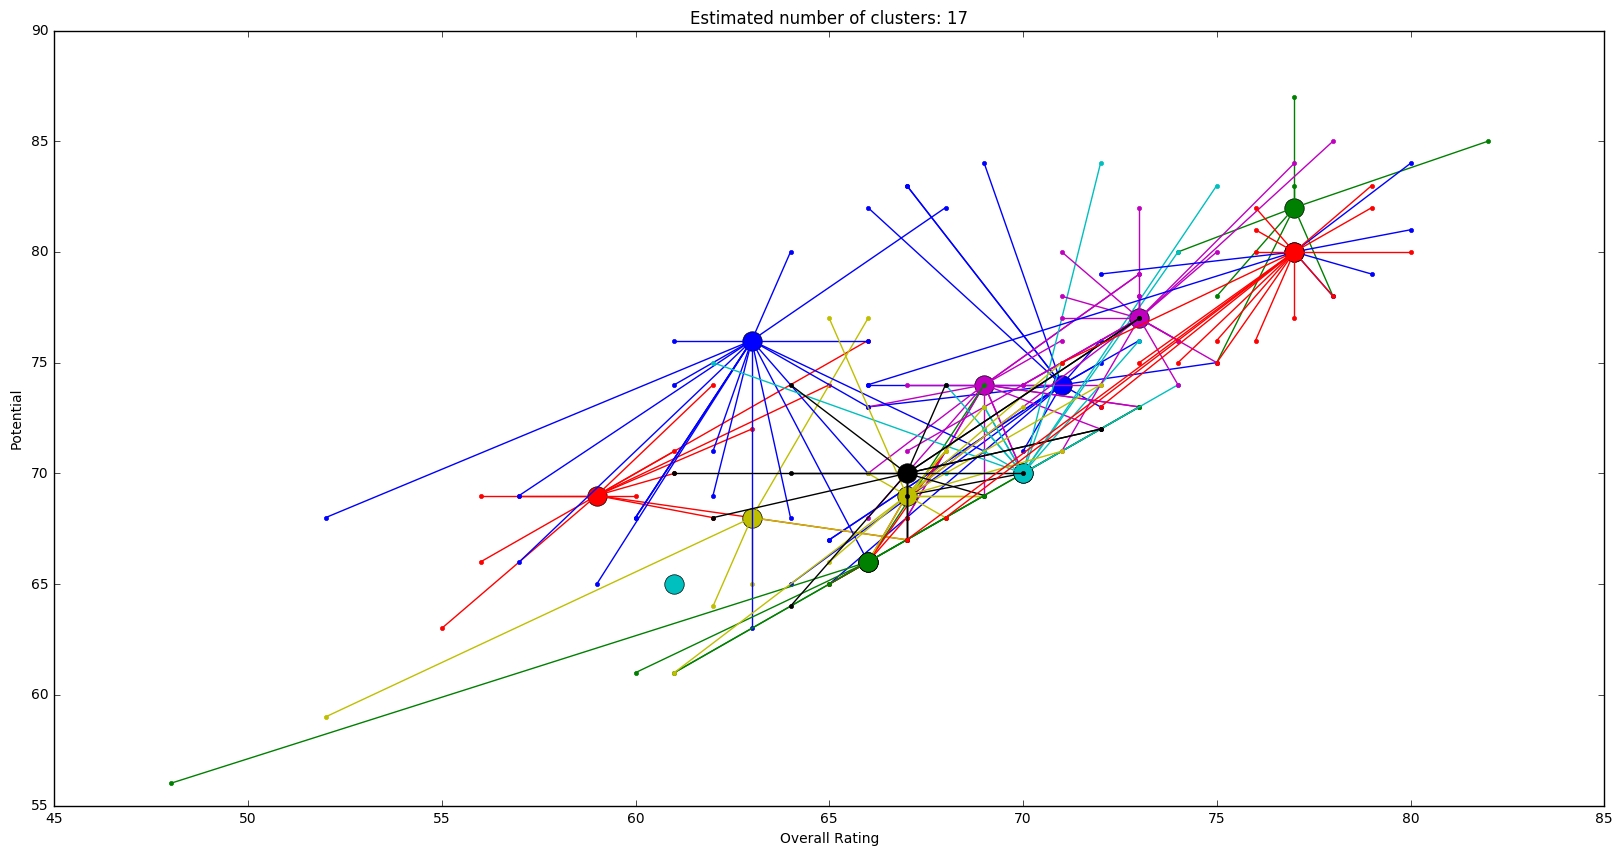

In [40]:
### Représentation dans le plan des deux premières variables des clusters obtenus

import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(figsize=(20,10))
plt.clf()
 
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = arr_train[cluster_centers_indices[k]]
    plt.plot(arr_train[class_members, 0], arr_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in arr_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.xlabel("Overall Rating")
plt.ylabel("Potential")   

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

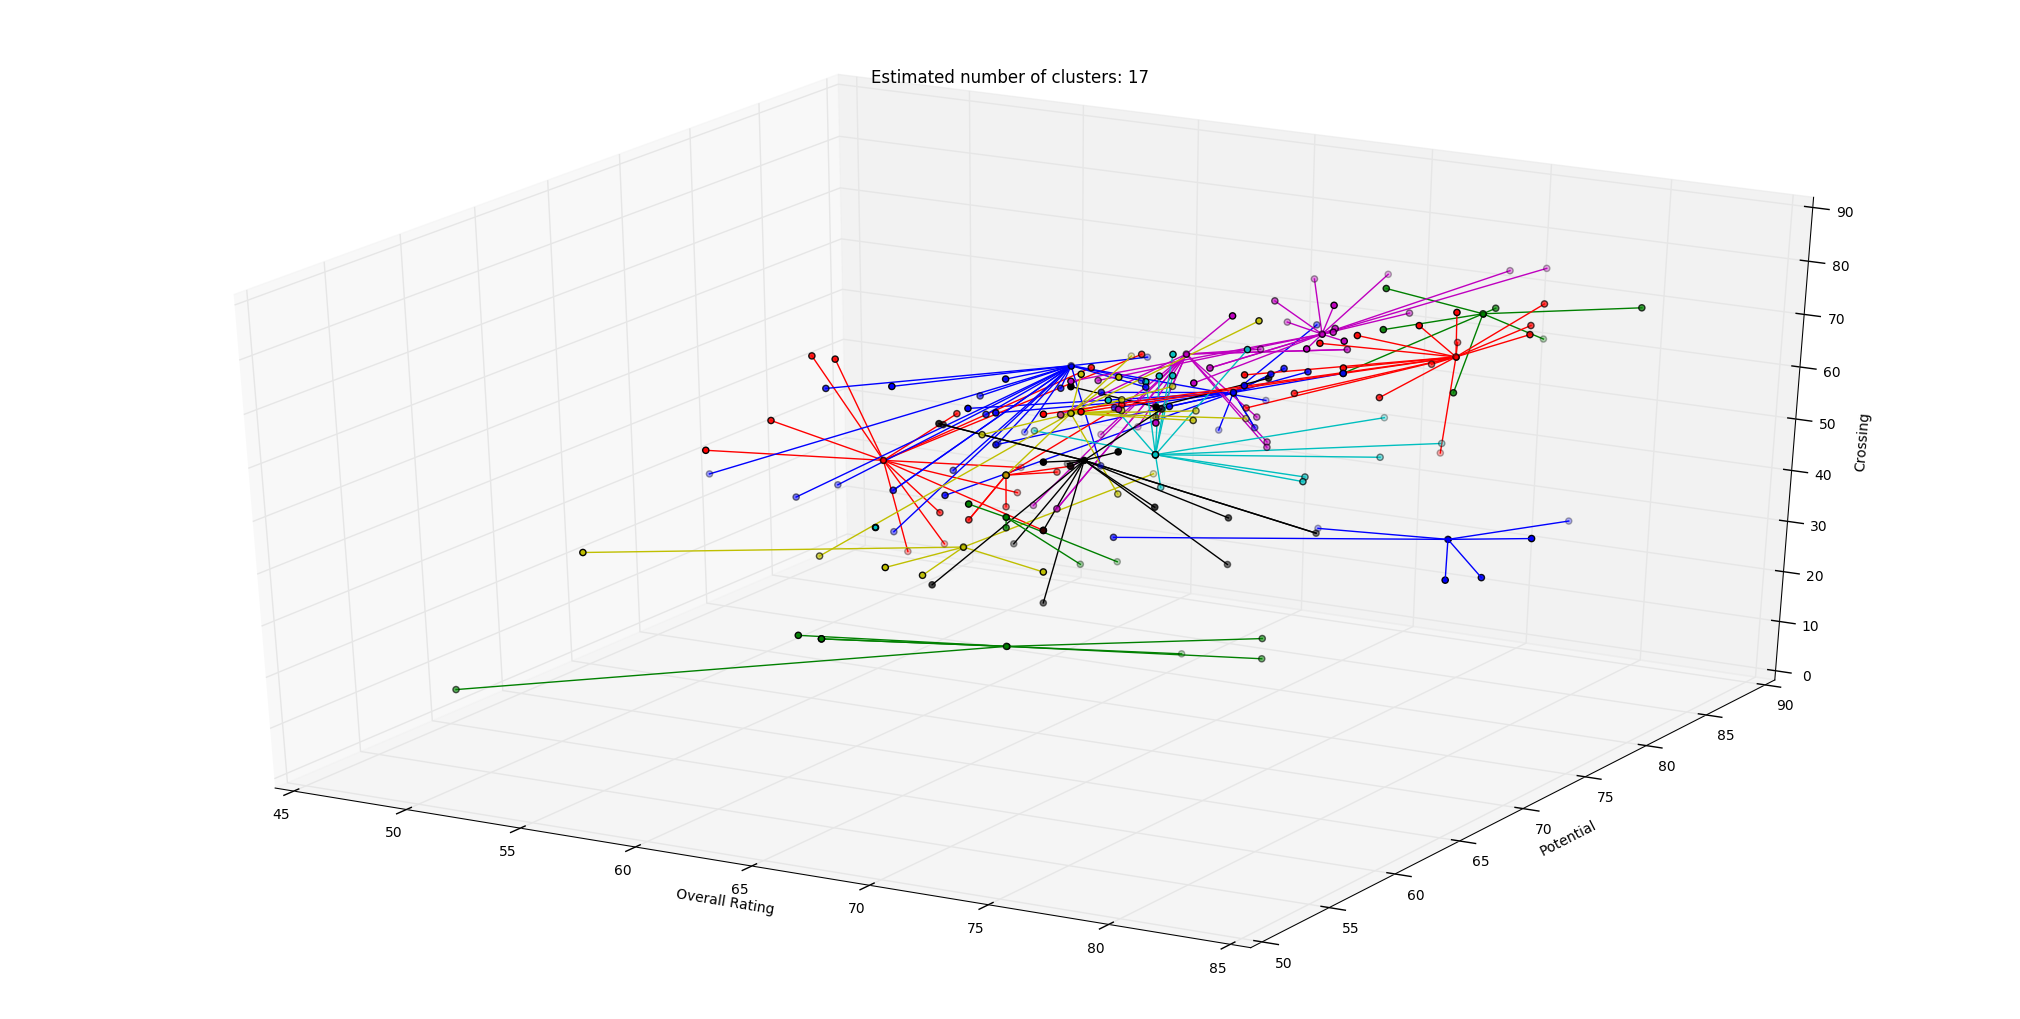

In [41]:
import matplotlib.pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

plt.close('all')

fig = pylab.figure(figsize =(20,10))
ax = Axes3D(fig)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = arr_train[cluster_centers_indices[k]]
    ax.scatter(arr_train[class_members, 0], arr_train[class_members, 1], arr_train[class_members, 2], c = col)
    ax.scatter(cluster_center[0], cluster_center[1], cluster_center[2], c = col,s = 14)
    for x in arr_train[class_members]:
        ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], [cluster_center[2], x[2]], c = col)

ax.set_xlabel("Overall Rating")
ax.set_ylabel("Potential")
ax.set_zlabel('Crossing')

ax.set_title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

## Conclusion de cette première application

Comme nous le montre les figures ci-dessus, la méthode AP produit sur cette base de données un nombre important de clusters. 

En effet, sur une base de données de 200 individus elle produit 17 clusters dont certains s'entremêlent.

Nous avons de plus un coefficient de silhouette de 0.255 ce qui n'est pas très élevé. 

Nous allons maintenant tenter d'appliquer la technique Map/Reduce à l'ensemble des données avant de critiquer le résultat obtenu.